## Reference

[Predicting the Winning Football Team](https://github.com/llSourcell/Predicting_Winning_Teams/blob/master/Prediction.ipynb)

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from IPython.display import display

%matplotlib inline

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Get Data

In [5]:
import urllib.request

data_url = "http://football-data.co.uk/mmz4281/1718/E0.csv"
local_filepath = "/tmp/football-history-example.csv"

urllib.request.urlretrieve(data_url, local_filepath)

% ls -al /tmp/football-history-example.csv

-rw-r--r-- 1 root root 5586 Aug 23 23:50 /tmp/football-history-example.csv


In [8]:
data = pd.read_csv(local_filepath)
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,11/08/17,Arsenal,Leicester,4,3,H,2,2,D,...,2.32,21,-1.00,1.91,1.85,2.10,2.02,1.49,4.73,7.25
1,E0,12/08/17,Brighton,Man City,0,2,A,0,0,D,...,2.27,20,1.50,1.95,1.91,2.01,1.96,11.75,6.15,1.29
2,E0,12/08/17,Chelsea,Burnley,2,3,A,0,3,A,...,2.23,20,-1.75,2.03,1.97,1.95,1.90,1.33,5.40,12.25
3,E0,12/08/17,Crystal Palace,Huddersfield,0,3,A,0,2,A,...,1.72,18,-0.75,2.10,2.05,1.86,1.83,1.79,3.56,5.51
4,E0,12/08/17,Everton,Stoke,1,0,H,1,0,H,...,1.76,19,-0.75,1.94,1.90,2.01,1.98,1.82,3.49,5.42


## Visualising distribution of Data

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f324db4fd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f324d625a20>]], dtype=object)

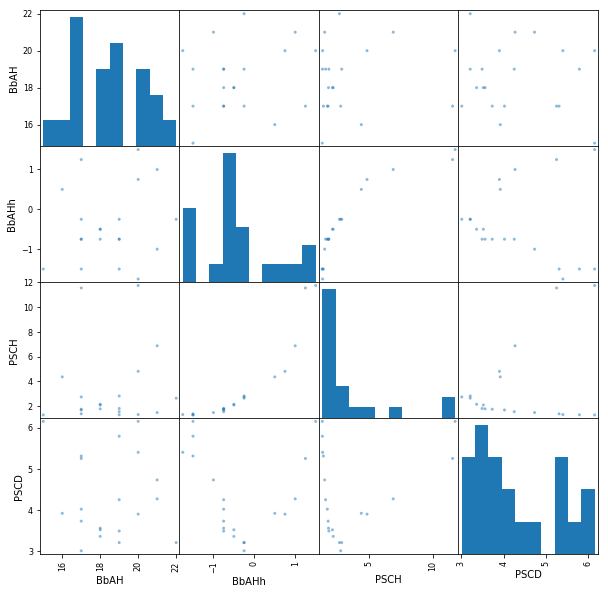

In [10]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(data[['BbAH','BbAHh','PSCH','PSCD']], figsize=(10, 10))

## Preparing the Data

In [95]:
# Use the following columns for train/predict
X_all = data[['BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA']] 
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
y_all = data['FTR'].values.tolist()

# Only reserve H and NH to make it binary prediction
# pandas Series tolist, the last element is Series itself, need to exclude it
y_all = pd.Series(list(map(lambda x: x if x == 'H' else 'NH', ll[:-1])))

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
for col in X_all:
    X_all[col] = scale(X_all[col])
    
X_all.head()

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,1.408590,-0.665636,-1.149628,-1.250347,1.437796,1.240825,-0.607644,0.420321,0.584443
1,0.845154,2.051244,-0.778780,-0.673264,0.583660,0.604505,2.716496,1.846501,-1.145950
2,0.845154,-1.480699,-0.037085,-0.096181,0.014236,-0.031816,-0.659482,1.093237,2.036116
3,-0.281718,-0.393948,0.611899,0.673264,-0.839901,-0.774190,-0.510447,-0.754770,0.079261
4,0.281718,-0.393948,-0.871492,-0.769444,0.583660,0.816611,-0.500727,-0.825075,0.053131


In [96]:
y_all.head()

0     H
1    NH
2    NH
3    NH
4     H
dtype: object

## Split Train / Test Set

In [97]:
from sklearn.cross_validation import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size=0.3,
                                                    random_state=2,
                                                    stratify=y_all)


## Helper Functions for Train / Evaluate different Classifiers

In [102]:
from time import time 
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    clf.fit(X_train, y_train)
    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    y_pred = clf.predict(features)
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print('f1 = {}, acc = {}'.format(f1, acc))
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))


## Evaluate different Classifiers

In [103]:
# Initialize the three models
clf_A = LogisticRegression(random_state=42)
clf_B = SVC(random_state=912, kernel='rbf')
clf_C = xgb.XGBClassifier(seed=82)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print('')


Training a LogisticRegression using a training set size of 14. . .
f1 = 0.7272727272727272, acc = 0.7857142857142857
F1 score and accuracy score for training set: 0.7273 , 0.7857.
F1 score and accuracy score for test set: 0.3333 , 0.3333.

Training a SVC using a training set size of 14. . .
f1 = 0.923076923076923, acc = 0.9285714285714286
F1 score and accuracy score for training set: 0.9231 , 0.9286.
F1 score and accuracy score for test set: 0.0000 , 0.3333.

Training a XGBClassifier using a training set size of 14. . .
f1 = 0.923076923076923, acc = 0.9285714285714286
F1 score and accuracy score for training set: 0.9231 , 0.9286.
F1 score and accuracy score for test set: 0.2857 , 0.1667.



## Tuning the parameters of XGBoost

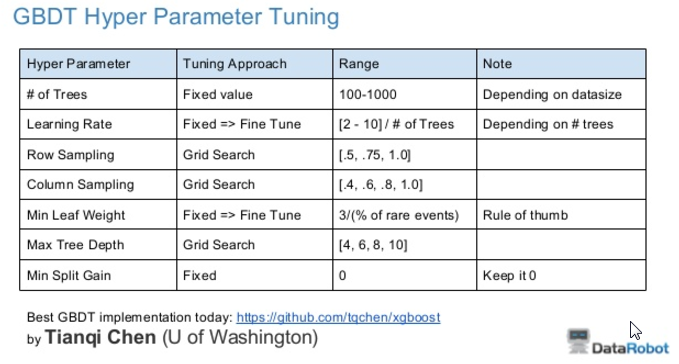

In [108]:
y_all

0      H
1     NH
2     NH
3     NH
4      H
5     NH
6     NH
7      H
8      H
9     NH
10    NH
11    NH
12     H
13     H
14     H
15     H
16    NH
17     H
18    NH
19    NH
dtype: object

In [119]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [5],     
               'max_depth': [3, 4, 5],
               'min_child_weight': [0.01],  # Minimum sum of instance weight(hessian) needed in a child
               'colsample_bytree' : [0.8],  # Subsample ratio of columns when constructing each tree
             }  

clf = xgb.XGBClassifier(seed=2)

f1_scorer = make_scorer(f1_score, pos_label='H')

grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

grid_obj = grid_obj.fit(X_all, y_all)

clf = grid_obj.best_estimator_
print(clf)

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf, X_test, y_test)
print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=0.01, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2, silent=True, subsample=1)
F1 score and accuracy score for training set: 0.8571 , 0.8571.
F1 score and accuracy score for test set: 1.0000 , 1.0000.


## Models

### Logistic Regression

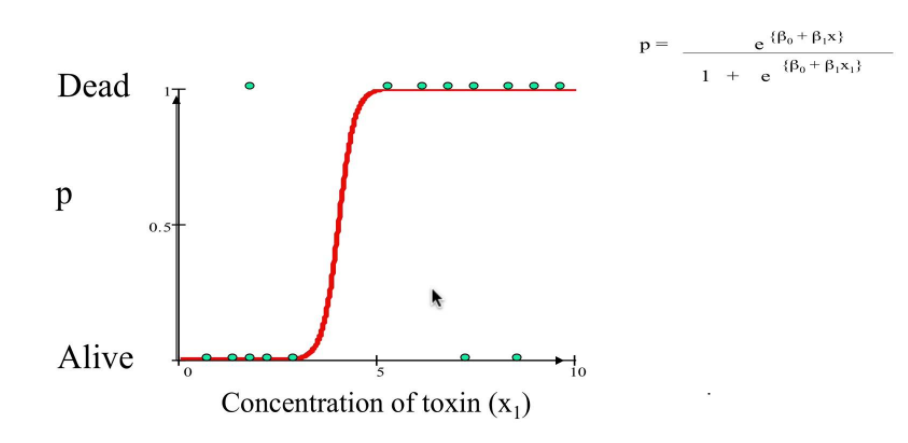

### SVM

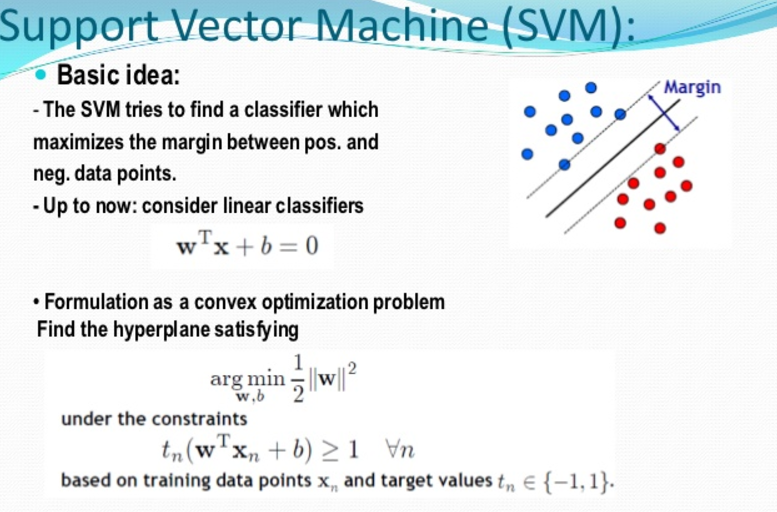

### XGBoost

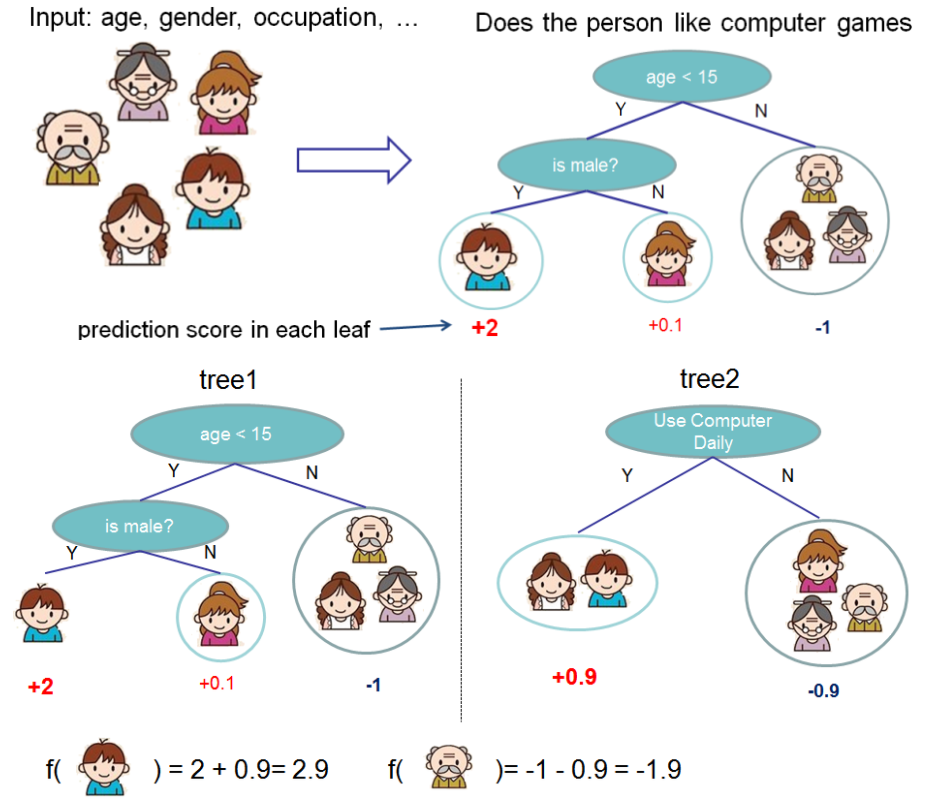